LightGBM not installed. Skipping this model.
Initial shape: (8523, 12) (rows, columns)

Missing values per column:
Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Dropped columns: 'Item_Identifier', 'Outlet_Identifier'

Normalized 'Item_Fat_Content': ['Low Fat' 'Regular' 'low fat' 'LF' 'reg'] ➔ ['Low Fat' 'Regular']

Filled 1463 missing 'Item_Weight' with median.
Filled 2410 missing 'Outlet_Size' with mode.

Replaced 526 zero values in 'Item_Visibility' with median.

Encoded Item_Fat_Content with 2 classes
Encoded Item_Type with 16 classes
Encoded Outlet_Size with 3 classes
Encoded Outlet_Location_Type with 3 classes
E

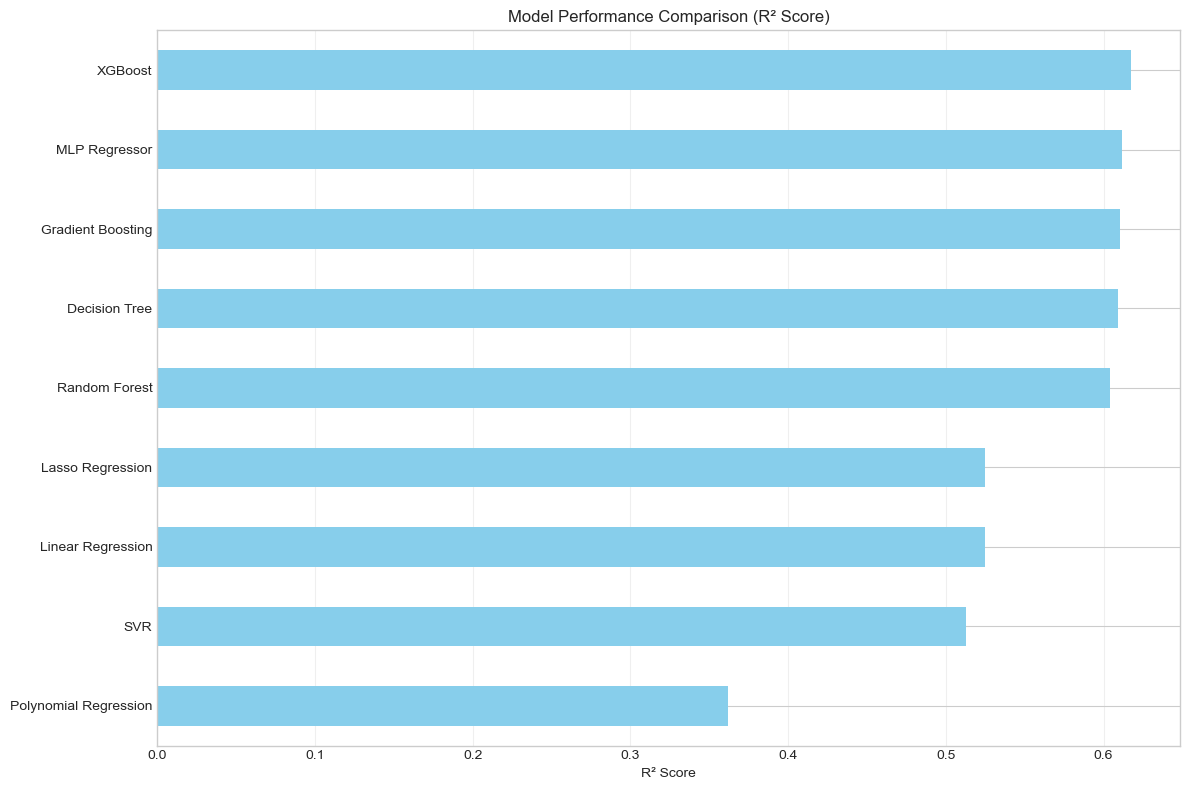

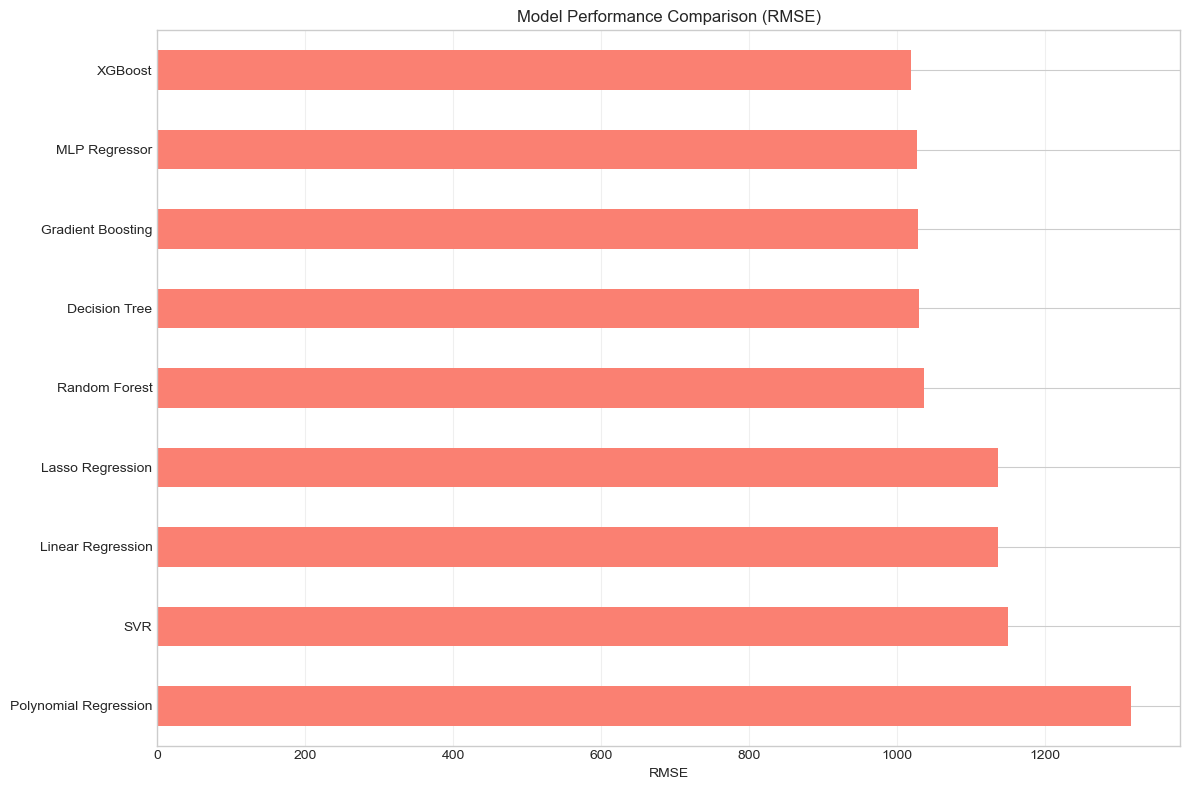


✅ Best Model: XGBoost
   R²: 0.6176
   RMSE: 1019.4540
   MAE: 716.8157

Top 10 Features for XGBoost:
                     Feature  Importance
8                Outlet_Type    0.360632
4                   Item_MRP    0.319291
5  Outlet_Establishment_Year    0.225437
6                Outlet_Size    0.029417
2            Item_Visibility    0.019613
3                  Item_Type    0.019140
0                Item_Weight    0.011741
1           Item_Fat_Content    0.008801
7       Outlet_Location_Type    0.005927


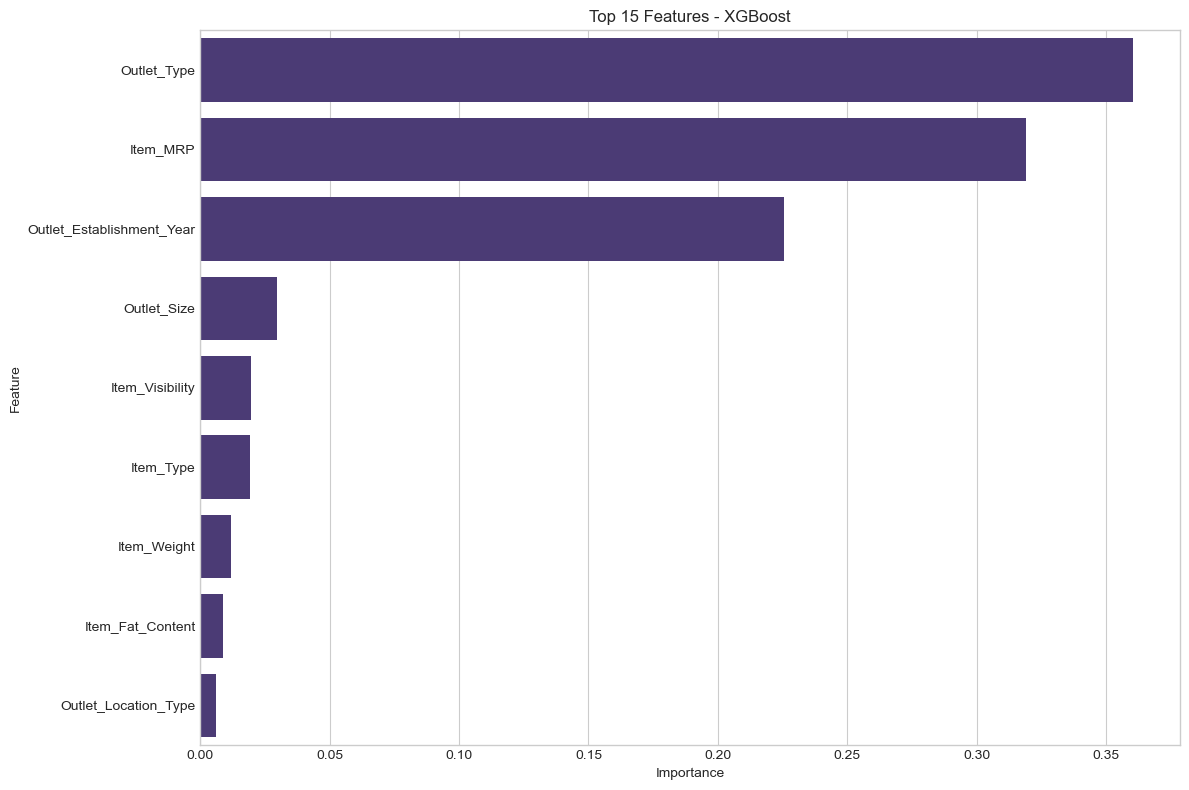

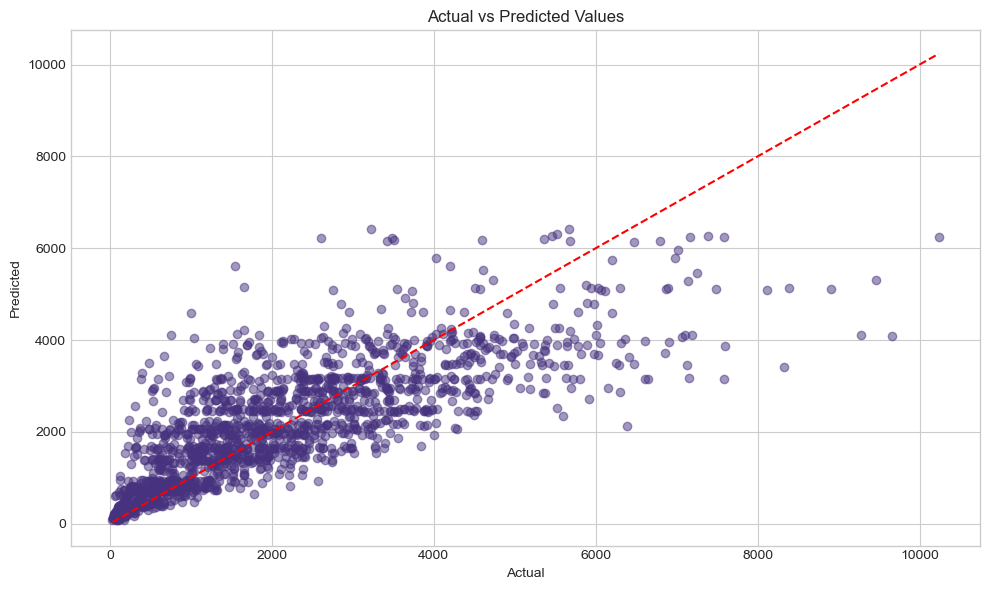

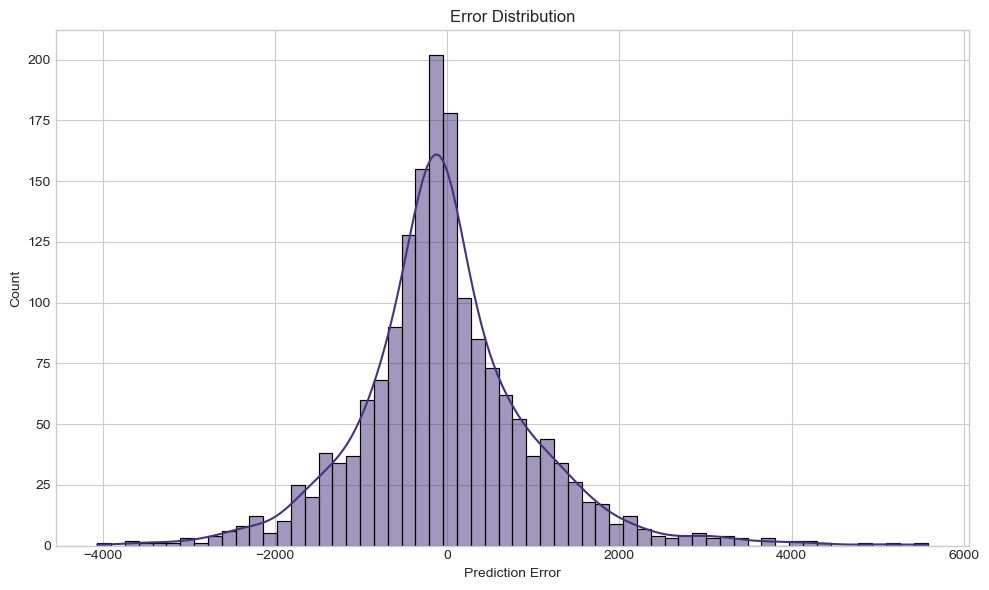


Analysis complete!


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Optional libraries with error handling
try:
    import lightgbm as lgb
    lightgbm_available = True
except ImportError:
    print("LightGBM not installed. Skipping this model.")
    lightgbm_available = False

try:
    import xgboost as xgb
    xgboost_available = True
except ImportError:
    print("XGBoost not installed. Skipping this model.")
    xgboost_available = False

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Load dataset
file_path = r"C:\Users\bavya\Downloads\minor\bigmart11\train.csv"  # Update this path as needed
df = pd.read_csv(file_path)
print(f"Initial shape: {df.shape} (rows, columns)\n")

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())
print()

# Drop unnecessary columns
df = df.drop(columns=['Item_Identifier', 'Outlet_Identifier'])
print("Dropped columns: 'Item_Identifier', 'Outlet_Identifier'\n")

# Normalize 'Item_Fat_Content'
before_unique = df['Item_Fat_Content'].unique()
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'})
after_unique = df['Item_Fat_Content'].unique()
print(f"Normalized 'Item_Fat_Content': {before_unique} ➔ {after_unique}\n")

# Fill missing values
missing_weight = df['Item_Weight'].isna().sum()
df['Item_Weight'] = df['Item_Weight'].fillna(df['Item_Weight'].median())
missing_size = df['Outlet_Size'].isna().sum()
df['Outlet_Size'] = df['Outlet_Size'].fillna(df['Outlet_Size'].mode()[0])
print(f"Filled {missing_weight} missing 'Item_Weight' with median.")
print(f"Filled {missing_size} missing 'Outlet_Size' with mode.\n")

# Handle zero 'Item_Visibility'
zero_vis_count = (df['Item_Visibility'] == 0).sum()
df['Item_Visibility'] = df['Item_Visibility'].replace(0, df[df['Item_Visibility'] > 0]['Item_Visibility'].median())
print(f"Replaced {zero_vis_count} zero values in 'Item_Visibility' with median.\n")

# Encode categorical features
cat_cols = df.select_dtypes(include='object').columns
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"Encoded {col} with {len(le.classes_)} classes")

# Split data for hyperparameter tuning
X = df.drop('Item_Outlet_Sales', axis=1)
y = df['Item_Outlet_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create polynomial features for Linear and Lasso models
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns[:5]
X_train_poly_subset = X_train[numerical_cols]
X_test_poly_subset = X_test[numerical_cols]

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_train = poly.fit_transform(X_train_poly_subset)
X_poly_test = poly.transform(X_test_poly_subset)

# ========== Hyperparameter Tuning for All Models ==========
print("\n========== Hyperparameter Tuning for All Models ==========")

best_params = {}

# 1. Linear Regression (No hyperparameters to tune, but including for completeness)
print("\n1. Tuning Linear Regression...")
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_r2 = r2_score(y_test, y_pred_lr)
print(f"Linear Regression baseline - RMSE: {lr_rmse:.2f}, R²: {lr_r2:.4f}")
best_params["Linear Regression"] = {}

# 2. Polynomial Regression (No hyperparameters to tune for the model itself)
print("\n2. Tuning Polynomial Regression...")
poly_reg = LinearRegression()
poly_reg.fit(X_poly_train, y_train)
y_pred_poly = poly_reg.predict(X_poly_test)
poly_rmse = np.sqrt(mean_squared_error(y_test, y_pred_poly))
poly_r2 = r2_score(y_test, y_pred_poly)
print(f"Polynomial Regression baseline - RMSE: {poly_rmse:.2f}, R²: {poly_r2:.4f}")
best_params["Polynomial Regression"] = {"degree": 2}  # We're using degree=2 in our PolynomialFeatures

# 3. Lasso Regression
print("\n3. Tuning Lasso Regression...")
# Addressing the convergence warning by trying different alphas and max_iter values
lasso_param_grid = {
    'alpha': [0.1, 0.5, 1.0, 5.0, 10.0],  # Higher alpha values for better regularization
    'max_iter': [3000, 5000]  # Increased number of iterations
}

lasso_grid = GridSearchCV(
    Lasso(random_state=42), 
    lasso_param_grid, 
    cv=3,  # Reduced CV folds to speed up tuning
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)
lasso_grid.fit(X_train_scaled, y_train)
print(f"Best Lasso parameters: {lasso_grid.best_params_}")
best_params["Lasso Regression"] = lasso_grid.best_params_

# 4. Decision Tree
print("\n4. Tuning Decision Tree...")
dt_param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_grid = GridSearchCV(
    DecisionTreeRegressor(random_state=42), 
    dt_param_grid, 
    cv=3, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)
dt_grid.fit(X_train_scaled, y_train)
print(f"Best Decision Tree parameters: {dt_grid.best_params_}")
best_params["Decision Tree"] = dt_grid.best_params_

# 5. Random Forest
print("\n5. Tuning Random Forest...")
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42), 
    rf_param_grid, 
    cv=3, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)
rf_grid.fit(X_train_scaled, y_train)
print(f"Best Random Forest parameters: {rf_grid.best_params_}")
best_params["Random Forest"] = rf_grid.best_params_

# 6. Gradient Boosting
print("\n6. Tuning Gradient Boosting...")
gb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}

gb_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42), 
    gb_param_grid, 
    cv=3, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)
gb_grid.fit(X_train_scaled, y_train)
print(f"Best Gradient Boosting parameters: {gb_grid.best_params_}")
best_params["Gradient Boosting"] = gb_grid.best_params_

# 7. SVR
print("\n7. Tuning SVR...")
svr_param_grid = {
    'kernel': ['rbf', 'linear'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1]
}

svr_grid = GridSearchCV(
    SVR(), 
    svr_param_grid, 
    cv=3, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)
svr_grid.fit(X_train_scaled, y_train)
print(f"Best SVR parameters: {svr_grid.best_params_}")
best_params["SVR"] = svr_grid.best_params_

# 8. MLP Regressor
print("\n8. Tuning MLP Regressor...")
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01]
}

mlp_grid = GridSearchCV(
    MLPRegressor(max_iter=1000, random_state=42), 
    mlp_param_grid, 
    cv=3, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)
mlp_grid.fit(X_train_scaled, y_train)
print(f"Best MLP parameters: {mlp_grid.best_params_}")
best_params["MLP Regressor"] = mlp_grid.best_params_

# 9. LightGBM (if available)
if lightgbm_available:
    print("\n9. Tuning LightGBM...")
    lgb_param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [31, 50, 80],
        'subsample': [0.8, 1.0]
    }
    
    lgb_grid = GridSearchCV(
        lgb.LGBMRegressor(random_state=42), 
        lgb_param_grid, 
        cv=3, 
        scoring='neg_mean_squared_error', 
        n_jobs=-1
    )
    lgb_grid.fit(X_train_scaled, y_train)
    print(f"Best LightGBM parameters: {lgb_grid.best_params_}")
    best_params["LightGBM"] = lgb_grid.best_params_

# 10. XGBoost (if available)
if xgboost_available:
    print("\n10. Tuning XGBoost...")
    xgb_param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    }
    
    xgb_grid = GridSearchCV(
        xgb.XGBRegressor(random_state=42), 
        xgb_param_grid, 
        cv=3, 
        scoring='neg_mean_squared_error', 
        n_jobs=-1
    )
    xgb_grid.fit(X_train_scaled, y_train)
    print(f"Best XGBoost parameters: {xgb_grid.best_params_}")
    best_params["XGBoost"] = xgb_grid.best_params_

# Print all best parameters together
print("\n========== Summary of Best Parameters ==========")
for model_name, params in best_params.items():
    print(f"{model_name}: {params}")

# Define models with tuned hyperparameters
models = {
    "Linear Regression": LinearRegression(),
    "Polynomial Regression": LinearRegression(),
    "Lasso Regression": Lasso(
        alpha=best_params["Lasso Regression"].get('alpha', 1.0),
        max_iter=best_params["Lasso Regression"].get('max_iter', 3000),
        random_state=42
    ),
    "Decision Tree": DecisionTreeRegressor(
        max_depth=best_params["Decision Tree"].get('max_depth', None),
        min_samples_split=best_params["Decision Tree"].get('min_samples_split', 2),
        min_samples_leaf=best_params["Decision Tree"].get('min_samples_leaf', 1),
        random_state=42
    ),
    "Random Forest": RandomForestRegressor(
        n_estimators=best_params["Random Forest"].get('n_estimators', 200),
        max_depth=best_params["Random Forest"].get('max_depth', None),
        min_samples_split=best_params["Random Forest"].get('min_samples_split', 2),
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=best_params["Gradient Boosting"].get('n_estimators', 200),
        learning_rate=best_params["Gradient Boosting"].get('learning_rate', 0.05),
        max_depth=best_params["Gradient Boosting"].get('max_depth', 5),
        random_state=42
    ),
    "SVR": SVR(
        kernel=best_params["SVR"].get('kernel', 'rbf'),
        C=best_params["SVR"].get('C', 10.0),
        gamma=best_params["SVR"].get('gamma', 'scale')
    ),
    "MLP Regressor": MLPRegressor(
        hidden_layer_sizes=best_params["MLP Regressor"].get('hidden_layer_sizes', (100, 50)),
        activation=best_params["MLP Regressor"].get('activation', 'relu'),
        alpha=best_params["MLP Regressor"].get('alpha', 0.0001),
        max_iter=1000,
        early_stopping=True,
        random_state=42
    )
}

# Add optional models with tuned parameters if available
if lightgbm_available:
    models["LightGBM"] = lgb.LGBMRegressor(
        n_estimators=best_params["LightGBM"].get('n_estimators', 200),
        learning_rate=best_params["LightGBM"].get('learning_rate', 0.05),
        num_leaves=best_params["LightGBM"].get('num_leaves', 31),
        subsample=best_params["LightGBM"].get('subsample', 0.8),
        random_state=42
    )

if xgboost_available:
    models["XGBoost"] = xgb.XGBRegressor(
        n_estimators=best_params["XGBoost"].get('n_estimators', 200),
        learning_rate=best_params["XGBoost"].get('learning_rate', 0.05),
        max_depth=best_params["XGBoost"].get('max_depth', 5),
        subsample=best_params["XGBoost"].get('subsample', 0.8),
        random_state=42
    )

# Train and evaluate models
results = {}
print("\nTraining and evaluating models:")

for name, model in models.items():
    print(f"Training {name}...")
    
    try:
        if name == "Polynomial Regression":
            model.fit(X_poly_train, y_train)
            y_pred = model.predict(X_poly_test)
        else:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Store results
        results[name] = {"MSE": mse, "RMSE": rmse, "MAE": mae, "R²": r2}
        print(f"  {name} - RMSE: {rmse:.2f}, R²: {r2:.4f}")
        
    except Exception as e:
        print(f"  Error with {name}: {str(e)}")
        continue

# Create results DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.sort_values("R²", ascending=False)

print("\n📊 Model Evaluation Results:")
print(results_df)

# Plot R² comparison
plt.figure(figsize=(12, 8))
results_df['R²'].sort_values().plot(kind='barh', color='skyblue')
plt.title('Model Performance Comparison (R² Score)')
plt.xlabel('R² Score')
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot RMSE comparison
plt.figure(figsize=(12, 8))
results_df['RMSE'].sort_values(ascending=False).plot(kind='barh', color='salmon')
plt.title('Model Performance Comparison (RMSE)')
plt.xlabel('RMSE')
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Print best model details
best_model_name = results_df['R²'].idxmax()
print(f"\n✅ Best Model: {best_model_name}")
print(f"   R²: {results_df.loc[best_model_name, 'R²']:.4f}")
print(f"   RMSE: {results_df.loc[best_model_name, 'RMSE']:.4f}")
print(f"   MAE: {results_df.loc[best_model_name, 'MAE']:.4f}")

# Feature importance for tree-based models
if best_model_name in ["Random Forest", "Gradient Boosting", "XGBoost", "LightGBM"]:
    best_model = models[best_model_name]
    
    # Get feature importance
    importance = best_model.feature_importances_
    feature_names = X.columns
    feature_importance = pd.DataFrame({"Feature": feature_names, "Importance": importance})
    feature_importance = feature_importance.sort_values("Importance", ascending=False)
    
    print(f"\nTop 10 Features for {best_model_name}:")
    print(feature_importance.head(10))

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x="Importance", y="Feature", data=feature_importance.head(15))
    plt.title(f"Top 15 Features - {best_model_name}")
    plt.tight_layout()
    plt.show()
    
    # Plot actual vs predicted
    if best_model_name != "Polynomial Regression":
        y_pred = best_model.predict(X_test_scaled)
    else:
        y_pred = models["Polynomial Regression"].predict(X_poly_test)
        
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted Values')
    plt.tight_layout()
    plt.show()
    
    # Plot error distribution
    errors = y_test - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=True)
    plt.title('Error Distribution')
    plt.xlabel('Prediction Error')
    plt.tight_layout()
    plt.show()

print("\nAnalysis complete!")